In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

# style.use('seaborn-v0_8-whitegrid')
from IPython.display import display

model_names = [
    'transformer',
    'resnet18',
    'resnet50'
    ]

# set this to be the same as the one in the experiment
model_idx = 2
batch_size = 256
model = model_names[model_idx]

data_file_pre = f'out/{model}_{batch_size}_pre.csv'
data_file_post = f'out/{model}_{batch_size}_post.csv'

df_pre = pd.read_csv(data_file_pre)
df_post = pd.read_csv(data_file_post)

In [65]:
def parse_and_plot(df, suffix='pre'):
    name_to_rank = {}
    for _, row in df.iterrows():
        name_to_rank[row['name']] = row['rank']

    df['type'].value_counts()
    display(df.head())
    # display(df['type'].value_counts())
    
    # some preprocessing
    df['mem_cuda_GB'] = df.mem_cuda * 1e-9
    df['mem_cuda_pre_GB'] = df.mem_cuda_pre * 1e-9
    df['mem_cuda_peak_GB'] = df.mem_cuda_peak * 1e-9


    op_start = df[df.op == 'call_function']['rank'].min()
    sep_rank = df[df.name == 'sep']['rank'].item()
    sep_back_rank = df[df.name == 'sep_backward']['rank'].item()
    opt_start = df[df.name == '_foreach_lerp_']['rank'].item()

    # print(op_start, sep_rank, sep_back_rank, opt_start)

    df_grad = df[:opt_start]

    # make sure to give a minimum allocation size
    # DOES NOT CHANGE ANYTHING
    # df['size'] = df['size'].where(df['size'] > 512, 512)

    # compute memory usage here

    memory_usage = np.zeros(df.shape[0])

    for _, row in df.iterrows():

        start = row['rank']
        if row['op'] == 'placeholder':
            start = 0
        end = df.shape[0]

        if not pd.isna(row['last_use']):
            end = name_to_rank[row['last_use']]

        memory_usage[start:end] += row['size']
    
    plt.grid()
    plt.plot(df.mem_cuda_GB, color = 'k', alpha=0.5, label='Memory consumption')
    plt.plot(memory_usage/1e9, color='b', alpha=0.6, label='Predicted Memory')

    plt.title('Memory consumption predicted vs. actual')
    plt.xlabel('Operations')
    plt.ylabel('Memory Consumption')

    plt.axvline(op_start, color='b', linestyle='--', alpha=0.3, label='Begin of forward pass')
    plt.axvline(sep_rank, color='r', linestyle='--', alpha=0.3, label='End of forward pass')
    plt.axvline(opt_start, color='g', linestyle='--', alpha=0.3, label = 'End of backward pass')
    plt.legend()
    plt.savefig(f'figs/memory_prediction_{model}_{batch_size}_{suffix}.png')
    plt.show()

,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,mem_cuda,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use
0,0,arg0_1,placeholder,arg0_1,[],"{convolution: None, convolution_backward_52: N...",37632.0,37632.0,0.019512,NodeType.PARAM,497733632,497733632,497733632,convolution,convolution,convolution_backward_52,copy__1932,copy__1932
1,1,arg0_2,placeholder,arg0_2,[],"{cudnn_batch_norm: None, cudnn_batch_norm_back...",256.0,256.0,0.012708,NodeType.PARAM,497733632,497733632,497733632,cudnn_batch_norm,cudnn_batch_norm,cudnn_batch_norm_backward_52,copy__1933,copy__1933
2,2,arg0_3,placeholder,arg0_3,[],"{cudnn_batch_norm: None, _foreach_addcdiv: Non...",256.0,256.0,0.011328,NodeType.PARAM,497733632,497733632,497733632,cudnn_batch_norm,cudnn_batch_norm,_foreach_addcdiv,copy__1934,copy__1934
3,3,arg0_4,placeholder,arg0_4,[],"{convolution_1: None, convolution_backward_51:...",16384.0,16384.0,0.010908,NodeType.PARAM,497733632,497733632,497733632,convolution_1,convolution_1,convolution_backward_51,copy__1935,copy__1935
4,4,arg0_5,placeholder,arg0_5,[],"{cudnn_batch_norm_1: None, cudnn_batch_norm_ba...",256.0,256.0,0.010448,NodeType.PARAM,497733632,497733632,497733632,cudnn_batch_norm_1,cudnn_batch_norm_1,cudnn_batch_norm_backward_51,copy__1936,copy__1936


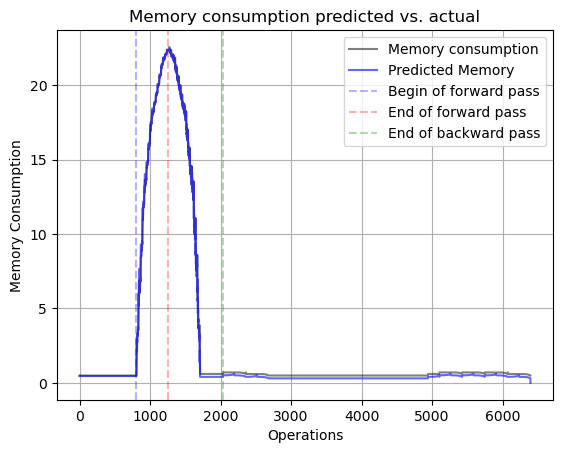

In [66]:
parse_and_plot(df_pre, suffix='pre')

,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,mem_cuda,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use
0,0,arg0_1,placeholder,arg0_1,[],"{convolution: None, convolution_backward_52: N...",37632.0,37632.0,0.018104,NodeType.PARAM,497733632,497733632,754634752,convolution,convolution,convolution_backward_52,copy__1932,copy__1932
1,1,arg0_2,placeholder,arg0_2,[],"{cudnn_batch_norm: None, cudnn_batch_norm_back...",256.0,256.0,0.015128,NodeType.PARAM,497733632,497733632,754634752,cudnn_batch_norm,cudnn_batch_norm,cudnn_batch_norm_backward_52,copy__1933,copy__1933
2,2,arg0_3,placeholder,arg0_3,[],"{cudnn_batch_norm: None, _foreach_addcdiv: Non...",256.0,256.0,0.012184,NodeType.PARAM,497733632,497733632,754634752,cudnn_batch_norm,cudnn_batch_norm,_foreach_addcdiv,copy__1934,copy__1934
3,3,arg0_4,placeholder,arg0_4,[],"{convolution_1: None, convolution_backward_51:...",16384.0,16384.0,0.010816,NodeType.PARAM,497733632,497733632,754634752,convolution_1,convolution_1,convolution_55,copy__1935,copy__1935
4,4,arg0_5,placeholder,arg0_5,[],"{cudnn_batch_norm_1: None, _foreach_addcdiv: N...",256.0,256.0,0.010568,NodeType.PARAM,497733632,497733632,754634752,cudnn_batch_norm_1,cudnn_batch_norm_1,cudnn_batch_norm_backward_51,copy__1936,copy__1936


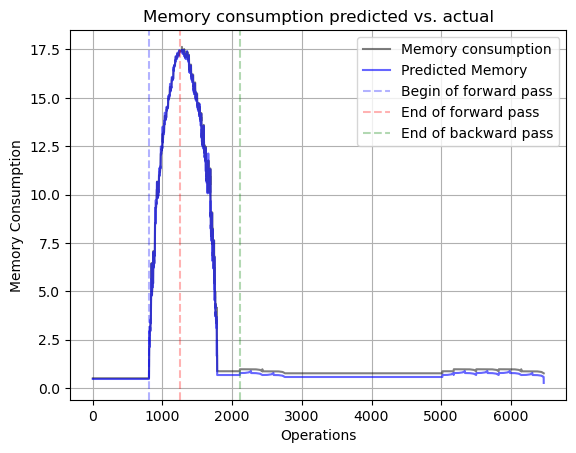

In [67]:
parse_and_plot(df_post, suffix='post')